In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download data
start_date = '1985-01-01'
end_date = '1989-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)

# Compute log returns
sp500_data = sp500_data[['Close']].dropna()
sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data.dropna(inplace=True)

# Add month column for grouping
sp500_data['Month'] = sp500_data.index.month

# Detect outliers using 3-sigma rule
mean = sp500_data['Log Return'].mean()
std = sp500_data['Log Return'].std()
threshold = 3
outliers = np.abs(sp500_data['Log Return'] - mean) > threshold * std

# Monthly average returns
monthly_avg_returns = sp500_data.groupby('Month')['Log Return'].mean()

# Print outliers and replacement values
print("Outliers and their replacements:\n")
for idx in sp500_data[outliers].index:
    date = idx.strftime('%Y-%m')
    original = sp500_data.loc[idx, 'Log Return']
    month = sp500_data.loc[idx, 'Month']
    replacement = monthly_avg_returns.loc[month]
    print(f"{date}: original={original:.4f}, replacement={replacement:.4f}")

# Replace outliers with monthly average
def replace_with_monthly_avg(row):
    if outliers.loc[row.name]:
        return monthly_avg_returns.loc[row['Month']]
    return row['Log Return']

sp500_data['Log Return'] = sp500_data.apply(replace_with_monthly_avg, axis=1)

# Drop helper column
sp500_data.drop(columns=['Month'], inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Outliers and their replacements:

1987-10: original=-0.2454, replacement=-0.0301


In [7]:
sp500_data.head(10)

Price,Close,Log Return
Date,,
1985-02-01,181.179993,0.008592
1985-03-01,180.660004,-0.002874
1985-04-01,179.830002,-0.004605
1985-05-01,189.550003,0.052641
1985-06-01,191.850006,0.012061
1985-07-01,190.919998,-0.004859
1985-08-01,188.630005,-0.012067
1985-09-01,182.080002,-0.035341
1985-10-01,189.820007,0.041630


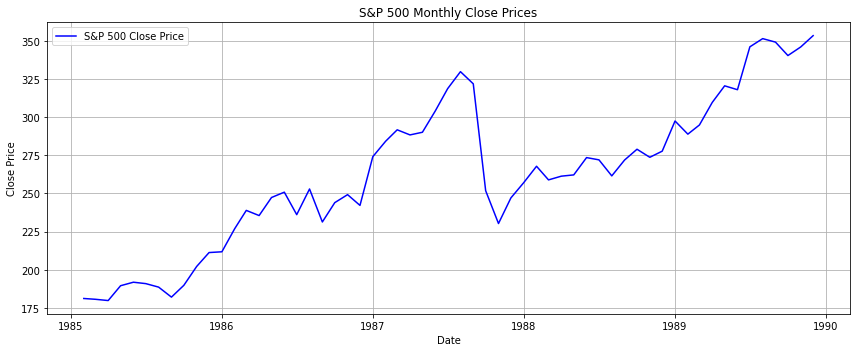

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

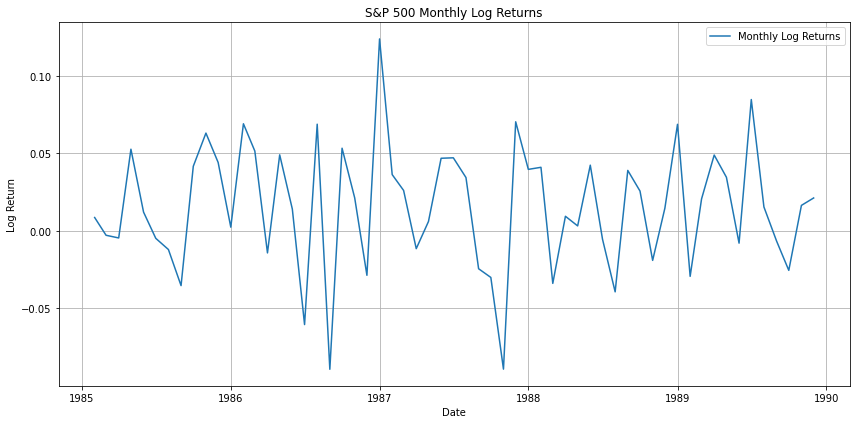

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

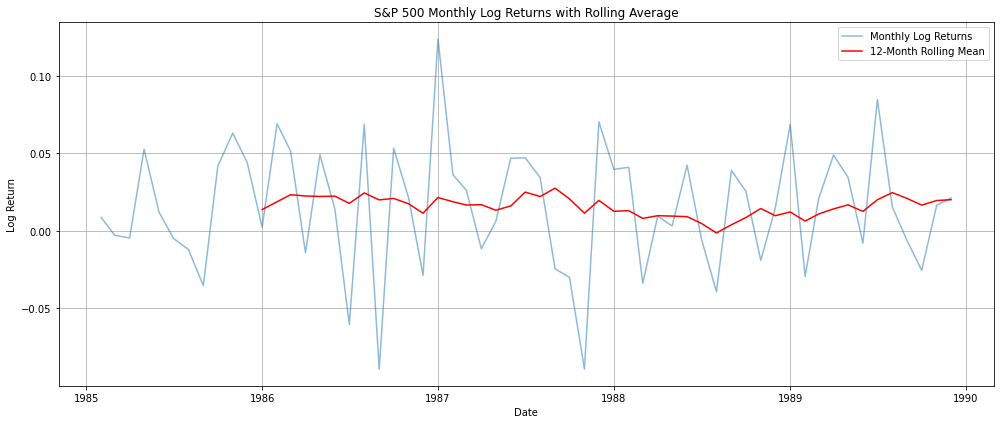

In [10]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

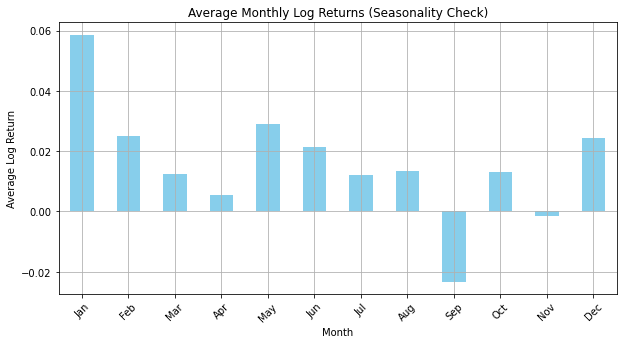

In [11]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 864x432 with 0 Axes>

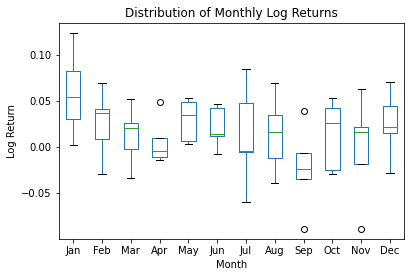

In [12]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [13]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -8.851838
p-value: 0.000000
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944


**Analysis:**

The ADF test shows the time series is stationary with a test statistic of -8.85 (much lower than critical values) and a p-value of 0.0000, rejecting the null hypothesis of non-stationarity.

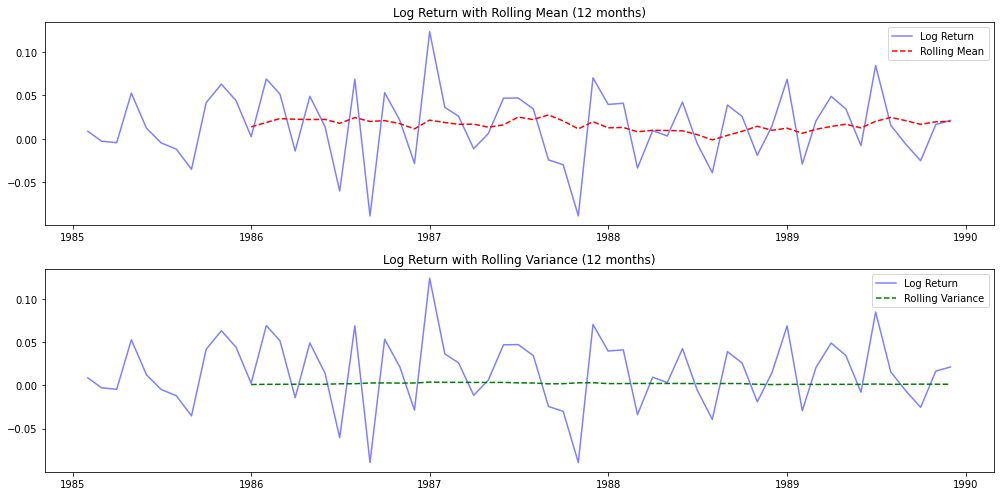

In [14]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

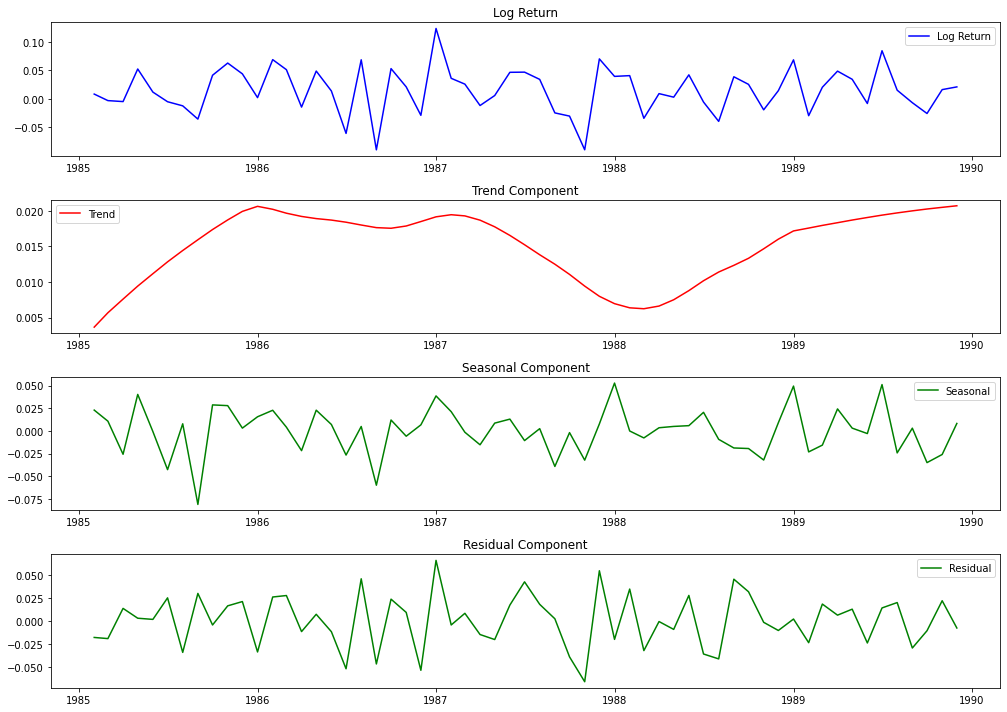

In [15]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                   59
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 109.255
Date:                Sun, 04 May 2025   AIC                           -210.509
Time:                        23:15:44   BIC                           -202.199
Sample:                    02-01-1985   HQIC                          -207.265
                         - 12-01-1989                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.001     13.384      0.000       0.013       0.017
ar.L1          0.7206      0.138      5.215      0.000       0.450       0.991
ma.L1         -0.9997     11.22

**Analysis:**

* Constant (coef = 0.0152, p = 0.000): The intercept is highly significant, indicating a consistent positive return in the log returns.

* AR(1) term (coef = 0.7206, p = 0.000): Strong positive autocorrelation, showing that current returns are highly influenced by the previous period's return.

In [18]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68505D+00    |proj g|=  8.88371D-01

At iterate    5    f= -1.69039D+00    |proj g|=  2.15516D+00

At iterate   10    f= -1.73497D+00    |proj g|=  1.73655D-01

At iterate   15    f= -1.73625D+00    |proj g|=  1.29422D+00

At iterate   20    f= -1.74141D+00    |proj g|=  8.70812D-02

At iterate   25    f= -1.74142D+00    |proj g|=  5.91335D-02

At iterate   30    f= -1.74183D+00    |proj g|=  4.48282D-01

At iterate   35    f= -1.74213D+00    |proj g|=  4.86766D-03

At iterate   40    f= -1.74215D+00    |proj g|=  1.25259D-03

At iterate   45    f= -1.74215D+00    |proj g|=  7.48409D-03

At iterate   50    f= -1.74217D+00    |proj g|=  5.63849D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

**Analysis:**

* Sigma² (coef = 0.0018, p = 0.000): Significant, indicating residual variance is an important part of the model, suggesting some degree of volatility.

In [23]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())


Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.057
Date:                Sun, 04 May 2025   Prob (F-statistic):              0.415
Time:                        23:19:12   Log-Likelihood:                 112.26
No. Observations:                  59   AIC:                            -200.5
Df Residuals:                      47   BIC:                            -175.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

* R-squared (0.198): The model explains only 19.8% of the variance in the log return, indicating a weak fit to the data.

* Constant (coef = 0.0586, p = 0.006): Significant, suggesting a positive baseline level for log return.

* Month 9 (coef = -0.0820, p = 0.004): Significant, indicating that September has a notably negative effect on log return.

* Month 11 (coef = -0.0601, p = 0.031): Significant, showing that November has a negative effect on log return.

* Other months: Many coefficients are insignificant (p > 0.05), indicating limited impact of those months on the log return.

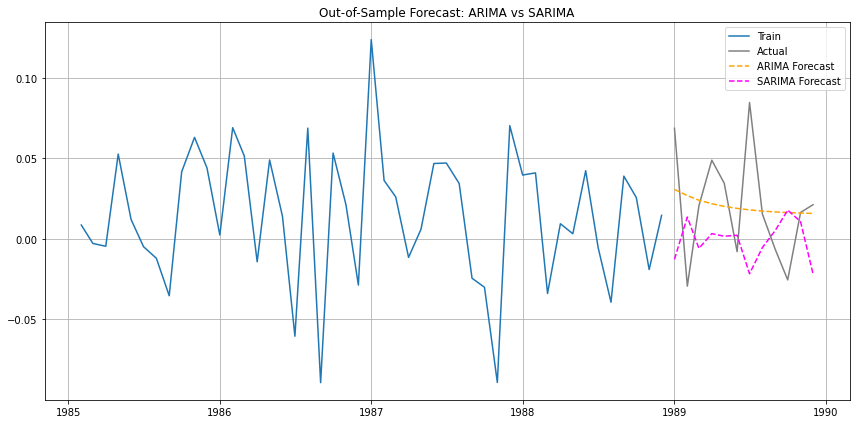

In [24]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

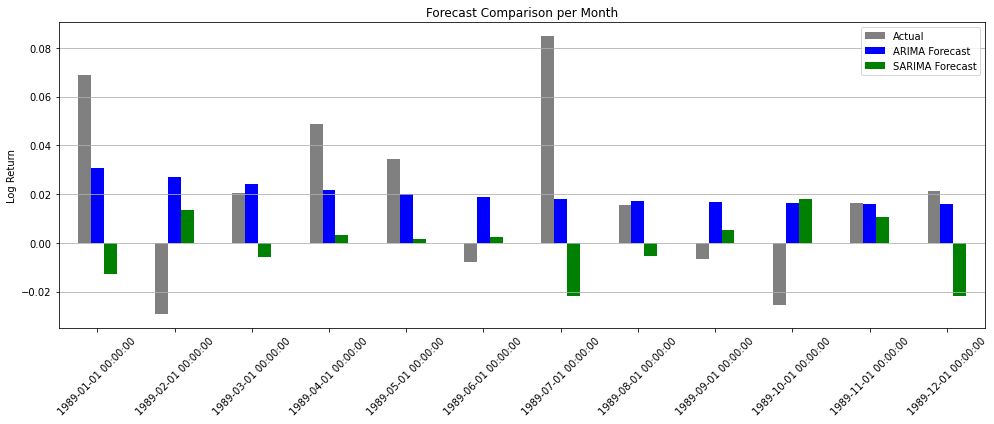

In [25]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

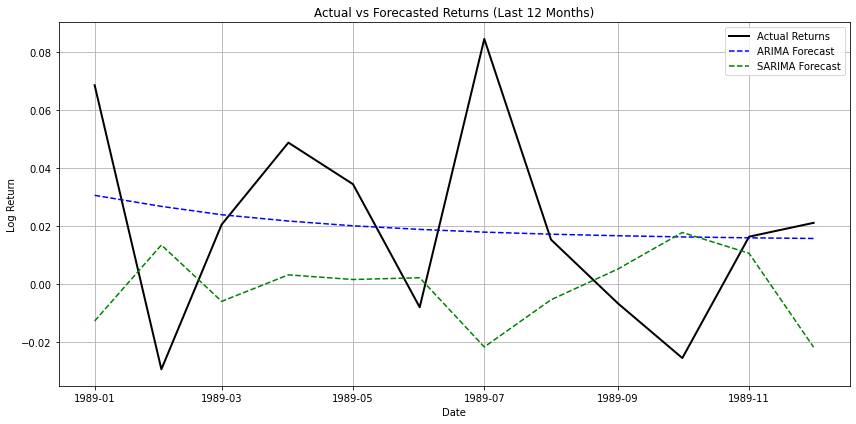

In [26]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.02545
ARIMA RMSE: 0.03298

SARIMA MAE: 0.03921
SARIMA RMSE: 0.04837


**Analysis:**

ARIMA outperforms SARIMA in forecast accuracy over the last 12 months, with lower MAE (0.02545 vs. 0.03921) and RMSE (0.03298 vs. 0.04837), indicating that ARIMA provides more accurate predictions for this period.

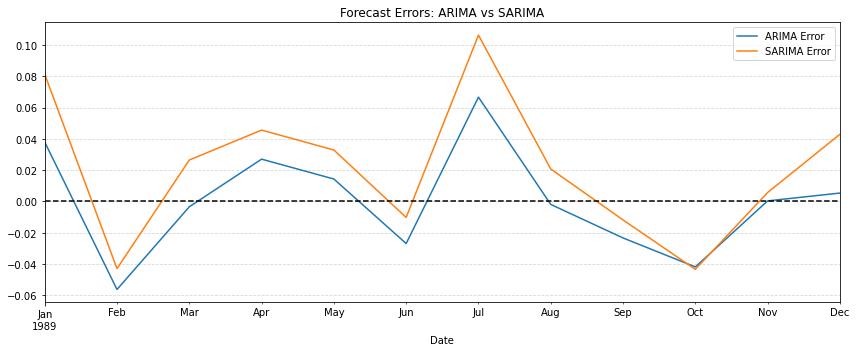

In [28]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()